In [18]:
import datasets
import gradio as gr


import torchmetrics
import pycocotools # make sure we have this for torchmetricsimport random

import numpy as np

import torch
import transformers

In [19]:
# Loading the dataset

from datasets import load_dataset
dataset = load_dataset("mrdbourke/trashify_manual_labelled_images")
dataset

Using the latest cached version of the dataset since mrdbourke/trashify_manual_labelled_images couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\heysr\.cache\huggingface\datasets\mrdbourke___trashify_manual_labelled_images\default\0.0.0\31fe55e7fa822727c84143d73084f4e3cefe0fbb (last modified on Tue Jul  8 04:30:29 2025).


DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 1128
    })
})

In [20]:
print(f"[INFO] Length of original dataset: {len(dataset['train'])}")



[INFO] Length of original dataset: 1128


In [21]:
# sample dataset 

dataset["train"][42]


{'image': <PIL.Image.Image image mode=RGB size=960x1280>,
 'image_id': 745,
 'annotations': {'file_name': ['094f4f41-dc07-4704-96d7-8d5e82c9edb9.jpeg',
   '094f4f41-dc07-4704-96d7-8d5e82c9edb9.jpeg',
   '094f4f41-dc07-4704-96d7-8d5e82c9edb9.jpeg'],
  'image_id': [745, 745, 745],
  'category_id': [5, 1, 0],
  'bbox': [[333.1000061035156,
    611.2000122070312,
    244.89999389648438,
    321.29998779296875],
   [504.0, 612.9000244140625, 451.29998779296875, 650.7999877929688],
   [202.8000030517578,
    366.20001220703125,
    532.9000244140625,
    555.4000244140625]],
  'iscrowd': [0, 0, 0],
  'area': [78686.3671875, 293706.03125, 295972.65625]},
 'label_source': 'manual_prodigy_label',
 'image_source': 'manual_taken_photo'}

In [22]:
#single bounding box 

dataset["train"][42]["annotations"]["bbox"][0]

[333.1000061035156, 611.2000122070312, 244.89999389648438, 321.29998779296875]

In [23]:
# X is the x-coordinate of the top left corner of the box (333.1).
# Y is the y-coordinate of the top left corner of the box (611.2).
# W is the width of the box (244.9).
# H is the height of the box (321.3).

In [24]:
categories = dataset["train"].features["annotations"].feature["category_id"]

# Get the names attribute
categories.names

['bin', 'hand', 'not_bin', 'not_hand', 'not_trash', 'trash', 'trash_arm']

In [25]:
id2label = {i: class_name for i, class_name in enumerate(categories.names)}
label2id = {value: key for key, value in id2label.items()}

In [26]:
print(f"Label to ID mapping:\n{label2id}\n")
print(f"ID to label mapping:\n{id2label}")

Label to ID mapping:
{'bin': 0, 'hand': 1, 'not_bin': 2, 'not_hand': 3, 'not_trash': 4, 'trash': 5, 'trash_arm': 6}

ID to label mapping:
{0: 'bin', 1: 'hand', 2: 'not_bin', 3: 'not_hand', 4: 'not_trash', 5: 'trash', 6: 'trash_arm'}


In [27]:
# Make colour dictionary
colour_palette = {
    'bin': (0, 0, 224),         # Bright Blue (High contrast with greenery) in format (red, green, blue)
    'not_bin': (255, 80, 80),   # Light Red to indicate negative class

    'hand': (148, 0, 211),      # Dark Purple (Contrasts well with skin tones)
    'not_hand': (255, 80, 80),  # Light Red to indicate negative class

    'trash': (0, 255, 0),       # Bright Green (For trash-related items)
    'not_trash': (255, 80, 80), # Light Red to indicate negative class

    'trash_arm': (255, 140, 0), # Deep Orange (Highly visible)
}

Small function to normalize our colour values from [0, 255] to [0, 1] (matplotlib expects our colour values to be between 0 and 1).

In [28]:
import matplotlib.pyplot as plt 
import numpy as np 


#normalize rgb values to 0-1 
def normalize_rgb(rgb_tuple):
    return tuple(x/255 for x in rgb_tuple)

# turn colors into normalized RGB values for matplotlib
colors_and_labels_rgb = [(key, normalize_rgb(value)) for key, value in colour_palette.items()]

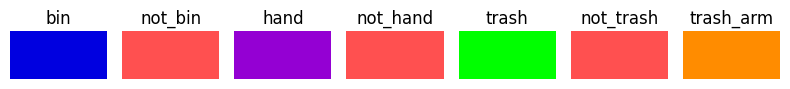

In [29]:
fig, ax = plt.subplots(1,7, figsize=(8,1))
ax = ax.flatten()

for idx, (label, color) in enumerate(colors_and_labels_rgb):
    ax[idx].add_patch(plt.Rectangle(xy=(0,0), width=1, height=1, facecolor=color))


    ax[idx].set_title(label)
    ax[idx].set_xlim(0, 1)
    ax[idx].set_ylim(0, 1)
    ax[idx].axis('off')

plt.tight_layout()
plt.show() 
    